In [1]:
import os
import scipy.io as sio

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh, norm, cg, minres, spsolve
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
import numpy as np
import time


In [2]:
'''
没有找到原来paper中的FIG. 4. 1.的26个矩阵数据，就根据paper提供的参考资源取了前26个中是spd的矩阵作为数据。 分别是ID1-4 和ID23-26
'''


# find path
os.chdir('/Users/gengxingri/Desktop/Leetcodes/HUAWEI/matrix_id')

# list of file names
file_names = [
    'id1_1138_bus.mat',
    'id2_494_bus.mat',
    'id3_662_bus.mat',
    'id4_685_bus.mat',
    'id23_bcsstk01.mat',
    'id24_bcsstk02.mat',
    'id25_bcsstk03.mat',
    'id26_bcsstk04.mat'
]

data_list = []

# read files
for file_name in file_names:
    data = sio.loadmat(file_name)
    data_list.append(data)


# find the matrix
matrix = []
for data in data_list:
    A = data['Problem']['A'][0][0]
    print(A.shape, type(A))
    matrix.append(A)




(1138, 1138) <class 'scipy.sparse._csc.csc_matrix'>
(494, 494) <class 'scipy.sparse._csc.csc_matrix'>
(662, 662) <class 'scipy.sparse._csc.csc_matrix'>
(685, 685) <class 'scipy.sparse._csc.csc_matrix'>
(48, 48) <class 'scipy.sparse._csc.csc_matrix'>
(66, 66) <class 'scipy.sparse._csc.csc_matrix'>
(112, 112) <class 'scipy.sparse._csc.csc_matrix'>
(132, 132) <class 'scipy.sparse._csc.csc_matrix'>


In [3]:

'''
eigval_min 还可以通过调整参数 maxiter和 tol 的值继续优化

''' 
# Calculate the condition number

def cond_num(A):
    eigval_max = eigsh(A, k=1, which='LM', return_eigenvectors=False)
    eigval_min = eigsh(A, k=1, which='SM', return_eigenvectors=False, maxiter=10000000, tol=1e-8)
    
    condition_number = eigval_max / eigval_min

    print("\nCondition number:", condition_number[0])
    return condition_number[0]


# condition numbers for 26 matrix   
original_cond = []
for A in matrix:
    original_cond.append(cond_num(A))
    


Condition number: 8572645.586340638

Condition number: 2415411.0180741954

Condition number: 794131.1078681493

Condition number: 423125.6373688753

Condition number: 882336.2627387453

Condition number: 4324.971460132286

Condition number: 6791333.064242624

Condition number: 2292466.0629935246


In [4]:
original_cond

[8572645.586340638,
 2415411.0180741954,
 794131.1078681493,
 423125.6373688753,
 882336.2627387453,
 4324.971460132286,
 6791333.064242624,
 2292466.0629935246]

In [7]:
# Calculate the condition number after preconditioning


# Create the diagonal preconditioner
def precond(A):
    
    n = A.shape[0]
    diag_A = A.diagonal()

    D = csc_matrix((1 / np.sqrt(diag_A), (np.arange(n), np.arange(n))), shape=(n, n))

    # Apply preconditioning
    A_new = D.dot(A.dot(D))
   
    return A_new


# condition number after preconditoning
def precond_num(A):
    A_new = precond(A)
    
    eigval_max = eigsh(A_new, k=1, which='LM', return_eigenvectors=False)
    eigval_min = eigsh(A_new, k=1, which='SM', return_eigenvectors=False, maxiter=10000000, tol=1e-8)

    condition_number = eigval_max / eigval_min

    print("\nCondition number after preconditioning:", condition_number[0])
    
    return condition_number[0]

# condition numbers for 26 matrix   
preconditioned_cond = []
for A in matrix:
    preconditioned_cond.append(precond_num(A))
    


Condition number after preconditioning: 490315.35817737883

Condition number after preconditioning: 78952.60173246905

Condition number after preconditioning: 44636.58466562711

Condition number after preconditioning: 8397.981393277698

Condition number after preconditioning: 1360.7070957468775

Condition number after preconditioning: 1812.1251147664118

Condition number after preconditioning: 14710.474466352714

Condition number after preconditioning: 1817.93888164568


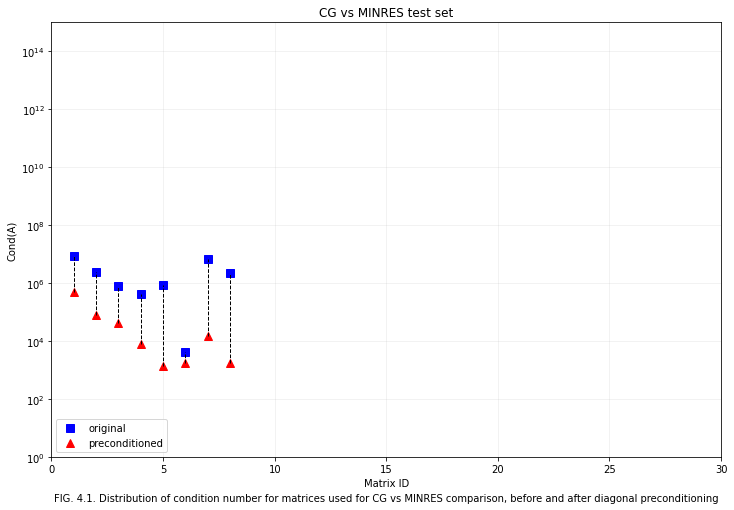

In [6]:
# The function to plot graph
def plot(matrix_ids, original_cond, precond_cond):
    
    plt.figure(figsize=(12, 8))
    
    # create a log scale plot for the y-axis.
    plt.semilogy(matrix_ids, original_cond, 'bs', markersize=8, label='original')
    plt.semilogy(matrix_ids, precond_cond, 'r^', markersize=8, label='preconditioned')
    
    # add the dashed vertical lines connecting the pairs of points
    for i in range(len(matrix_ids)):
        plt.vlines(matrix_ids[i], 
                   min(original_cond[i], precond_cond[i]), 
                   max(original_cond[i], precond_cond[i]), 
                   'k', 
                   linestyle='dashed', 
                   linewidth=1)

    plt.xlabel('Matrix ID')
    plt.ylabel('Cond(A)')
    plt.title('CG vs MINRES test set')
    
    # add the legend
    plt.legend(loc = 'lower left')
    
    # set the axis limits
    plt.xlim(0, 30)
    plt.ylim(1e0, 1e15)
    
    # add a light grid to the background
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # add text
    plt.text(0.5, 
            -0.1, 
            'FIG. 4.1. Distribution of condition number for matrices used for CG vs MINRES comparison, before and after diagonal preconditioning',
            transform=plt.gca().transAxes, 
            ha='center')

    
    plt.show()
    
    
# plot the graph
matrix_ids = np.arange(1, 9)

plot(matrix_ids, original_cond, preconditioned_cond)